In [16]:
import pandas as pd
import jieba
import json
import matplotlib.pyplot as plt
import math
import pymongo
import time
from datetime import datetime

## Description

The tool is the prototype of the Sentiment Analysis Tool (SAT) that requires many inputs and with a basic dataframe structure.

In [2]:
# 定义DataFrame

columns = ['source', 'title', 'content', 'date', 'ifRelevant', 'currentScore']
df = pd.DataFrame(columns = columns)

In [32]:
# Parameter and Weight

def initialization():
    
    # institution weight
    institutionWeight = {}
    institutionFile = open('institutionWeight.txt', 'r')
    for line in institutionFile.readlines():
        ins, weight = line.split(': ')
        institutionWeight[str(ins.strip())] = float(weight.strip())
    institutionFile.close()
        
    # source weight    
    sourceWeight = {}
    sourceFile = open('sourceWeight.txt', 'r')
    for line in sourceFile.readlines():
        source, weight = line.split(': ')
        sourceWeight[str(source.strip())] = float(weight.strip())
    sourceFile.close()
    
    # positive sentiment vocabs
    positiveSentimentVocabs = {}
    positiveSentimentVocabsFile = open('positiveSentimentVocabs.txt', 'r')
    for line in positiveSentimentVocabsFile.readlines():
        vocab, weight = line.split(': ')
        positiveSentimentVocabs[str(vocab.strip())] = float(weight.strip())
    positiveSentimentVocabsFile.close()
    
    # negative sentiment vocabs
    negativeSentimentVocabs = {}
    negativeSentimentVocabsFile = open('negativeSentimentVocabs.txt', 'r')
    for line in negativeSentimentVocabsFile.readlines():
        vocab, weight = line.split(': ')
        negativeSentimentVocabs[str(vocab.strip())] = float(weight.strip())
    negativeSentimentVocabsFile.close()
        
    return institutionWeight, sourceWeight, positiveSentimentVocabs, negativeSentimentVocabs

In [72]:
def plotScores(score, bytype):
    plt.figure(figsize=(10,8))
    plt.plot(score)
    
    plt.xlabel('Timeline')
    plt.ylabel('Sentiment')
    plt.title('Sentiment By ' + bytype)
    
    plt.show()

In [78]:
# Main function

def SAT(hotwords, filename):
    columns = ['source', 'title', 'content', 'date', 'ifRelevant', 'currentScoreBySource', 'currentScoreByIns']
    df = pd.DataFrame(columns = columns)
    file = open(filename, 'r')
    
    institutionWeight, sourceWeight, positive_words, negative_words = initialization()
    
    for line in file.readlines():
        year, month, day, time = json.loads(line[:-1])['dateAdded'].split('-')
        source = json.loads(line[:-1])['source']
        title = json.loads(line[:-1])['title']
        content = json.loads(line[:-1])['content']
        ifRelevant = 0
        for words in hotwords:
            if words in content:
                ifRelevant = 1
                break
        row = {'source': source, 'title': title, 'content': content, 'date': str(year + '-' + month + '-' + day), 'ifRelevant': ifRelevant}
        df = df.append(row, ignore_index = True)
        
    df['date'] = pd.to_datetime(df['date'])
    
    relevant_df = df[df['ifRelevant'] == 1]
    
    # analysis loop
    initScoresBySource = [50]
    dateTimeBySource = [0]
    
    # By Source
    for i in range(len(relevant_df)):
        currentScoreBySource = initScoresBySource[-1]
        sentences = relevant_df.iloc[i, 2].replace('\u3000', '').split('。')
        for sentence in sentences:
            for sourceKey in sourceWeight.keys():
                if sourceKey in sentence:
                    for word in hotWords:
                        for sentiment in positive_words.keys():
                            if sentiment in sentence:
                                currentScoreBySource += (positive_words[sentiment] * sourceWeight[sourceKey])
                        for sentiment in negative_words.keys():
                            if sentiment in sentence:

                                currentScoreBySource += (negative_words[sentiment] * sourceWeight[sourceKey])

        initScoresBySource.append(currentScoreBySource)
        dateTimeBySource.append(relevant_df.iloc[i]['date'])
        
#     result_df = pd.DataFrame(initScoresBySource, dateTimeBySource)
        

    plotScores(initScoresBySource, 'Source')
    
    initScoresByIns = [50]
    dateTimeByIns = [0]
    
    # By Institution
    for i in range(len(relevant_df)):
        currentScoreByIns = initScoresByIns[-1]
        sentences = relevant_df.iloc[i, 2].replace('\u3000', '').split('。')
        for sentence in sentences:
            for insKey in institutionWeight.keys():
                if insKey in sentence:
                    for word in hotWords:
                        for sentiment in positive_words.keys():
                            if sentiment in sentence:
                                currentScoreByIns += (positive_words[sentiment] * institutionWeight[insKey])
                        for sentiment in negative_words.keys():
                            if sentiment in sentence:

                                currentScoreByIns += (negative_words[sentiment] * institutionWeight[insKey])

        initScoresByIns.append(currentScoreByIns)
        dateTimeByIns.append(relevant_df.iloc[i]['date'])
        
    plotScores(initScoresByIns, 'Institution')
    

In [83]:
# Please define your hot-words here

hotWords = ['网络直播'] # Enter here


# Run result
SAT(hotwords=hotWords, filename='news')

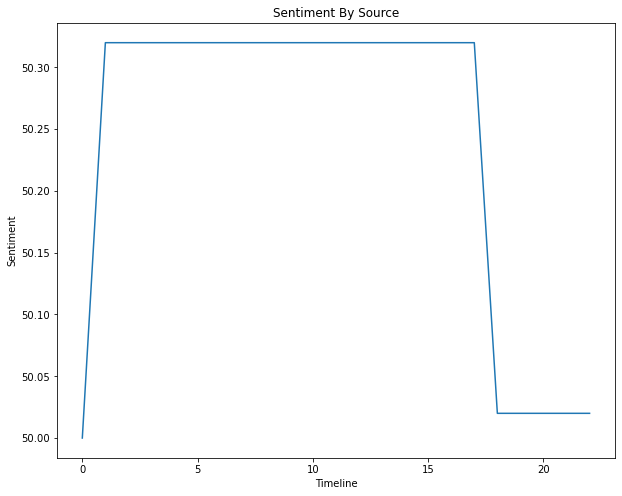

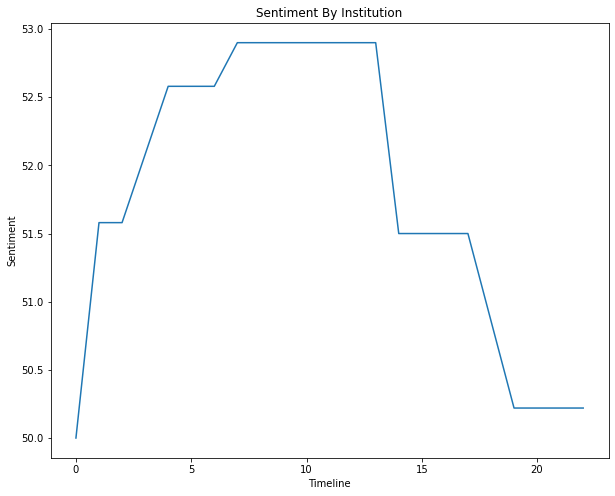

# 直连MongoDB版本

In [14]:
myClient = pymongo.MongoClient('mongodb://localhost:27017/')
dblist = myClient.list_database_names()
# Test if db existed
if 'ttd' in dblist:
    print('DB existed')
mydb = myClient['ttd']
cList = mydb.list_collection_names()
import pymongo
from datetime import datetime
import time
# 标记过的新闻库
if 'taggedNews' in cList:
    print('Collection existed')
else:
    print('Create collection')
    
taggedNews = mydb['taggedNews']

# 得分库

if 'scoreBase' in cList:
    print('Collection existed')
else:
    print('Create collection')

scoreBase = mydb['scoreBase']

DB existed
Collection existed
Create collection


## 预设Method

In [7]:
def initialization():
    
    # institution weight
    institutionWeight = {}
    institutionFile = open('referenceList/institutionWeight.txt', 'r')
    for line in institutionFile.readlines():
        ins, weight = line.split(': ')
        institutionWeight[str(ins.strip())] = float(weight.strip())
    institutionFile.close()
        
    # source weight    
    sourceWeight = {}
    sourceFile = open('referenceList/sourceWeight.txt', 'r')
    for line in sourceFile.readlines():
        source, weight = line.split(': ')
        sourceWeight[str(source.strip())] = float(weight.strip())
    sourceFile.close()
    
    # positive sentiment vocabs
    positiveSentimentVocabs = {}
    positiveSentimentVocabsFile = open('referenceList/positiveSentimentVocabs.txt', 'r')
    for line in positiveSentimentVocabsFile.readlines():
        vocab, weight = line.split(': ')
        positiveSentimentVocabs[str(vocab.strip())] = float(weight.strip())
    positiveSentimentVocabsFile.close()
    
    # negative sentiment vocabs
    negativeSentimentVocabs = {}
    negativeSentimentVocabsFile = open('referenceList/negativeSentimentVocabs.txt', 'r')
    for line in negativeSentimentVocabsFile.readlines():
        vocab, weight = line.split(': ')
        negativeSentimentVocabs[str(vocab.strip())] = float(weight.strip())
    negativeSentimentVocabsFile.close()
        
    return institutionWeight, sourceWeight, positiveSentimentVocabs, negativeSentimentVocabs

In [11]:
print('今天是', time.localtime().tm_year, '年', time.localtime().tm_mon, '月', time.localtime().tm_mday, '日，即将计算当日分数......')

今天是 2020 年 9 月 26 日，即将计算当日分数......


In [19]:
type(time.localtime().tm_year)

int

In [120]:
firms = []
file = open('referenceList/firmList.txt', 'r')
for line in file.readlines():
    firms.append(line.strip())
file.close()




def analysis(target, content):
    institutionWeight, sourceWeight, positive_words, negative_words = initialization()
    currentScore = [0]
    
    for sentence in content.split('。'):
        for word in positive_words:
            for institution in institutionWeight:
                if word in sentence and institution in sentence:
                    currentScore.append(currentScore[-1] + institutionWeight[institution] * positive_words[word])
        
        for word in negative_words:
            for institution in institutionWeight:
                if word in sentence and institution in sentence:
                    currentScore.append(currentScore[-1] + institutionWeight[institution] * negative_words[word])
                    
    return currentScore

def SAT(firms, givenDate):

    data = taggedNews.find({'dateAdded': givenDate})
    
    firmScore = pd.DataFrame(columns = ['firmName', 'firmScore', 'scoreDate'])
    
    for line in data:
        for firm in firms:
            if firm in line['firmsTag']:
                # 触发分析
               
                score = analysis(firm, line['content'])
                firmScore = firmScore.append({'firmName': firm, 'firmScore': round(float(score[-1]),2), 'scoreDate': givenDate}, ignore_index = True)
                
    result = firmScore.groupby('firmName').sum()
    
    result = result.reset_index()
    result['firmScore'] = round(result['firmScore'], 2)
    for firm in firms:
        if firm not in list(result['firmName']):
            
            result = result.append({'firmName': firm,'firmScore': round(float(0), 2)}, ignore_index = True)
    return result

In [107]:
# year = time.localtime().tm_year
# month = time.localtime().tm_mon
# day = time.localtime().tm_mday
#     givenDate = datetime(year, month, day, 0, 0)
givenDate = datetime(2020, 9, 9, 0, 0)

SAT(firms, givenDate)

,firmName,firmScore
0,亚马逊,0.00
1,京东,0.10
2,字节跳动,0.00
3,微软,0.00
4,腾讯,0.00
5,谷歌,0.00
6,阿里巴巴,3.84
7,百度,0.00
8,滴滴,0.00
9,甲骨文,0.00


In [112]:
date = set()
for line in taggedNews.find():
    if '字节跳动' in line['firmsTag']:
        date.add(line['dateAdded'])
    

In [121]:
for time in date:
    current = SAT(firms, time)
    for i in range(len(current)):
        scoreBase.insert_one({'firmName': current.iloc[i]['firmName'],
                              'firmScore': current.iloc[i]['firmScore'],
                              'scoreDate': time})
        

In [117]:
givenDate = datetime(2020, 9, 9, 0, 0)

temp = SAT(firms, givenDate)
temp

,firmName,firmScore
0,亚马逊,0.00
1,京东,0.10
2,字节跳动,0.00
3,微软,0.00
4,腾讯,0.00
5,谷歌,0.00
6,阿里巴巴,3.84
7,百度,0.00
8,滴滴,0.00
9,甲骨文,0.00


In [118]:
temp['firmScore'] = round(temp['firmScore'], 1)

In [119]:
temp

,firmName,firmScore
0,亚马逊,0.0
1,京东,0.1
2,字节跳动,0.0
3,微软,0.0
4,腾讯,0.0
5,谷歌,0.0
6,阿里巴巴,3.8
7,百度,0.0
8,滴滴,0.0
9,甲骨文,0.0
